In [12]:
import os
dataset_path = 'D:\DOWNLOADS\DDD\c-spine_nor'
st=set()

for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        file_extension = pathlib.Path(filename).suffix
        st.add(file_extension)

In [9]:
print(st)
 


{'.129904247d,kytJPG', '.JPG', '.jpeg', '.jpg'}


In [11]:
print(st)

{'.JPG', '.jpg', '.jpeg'}


In [13]:
print(st)

{'.JPG', '.jpg'}


In [ ]:
('.129904247d,kytJPG', '.JPG', '.jpeg', '.jpg','.JPG', '.jpg', '.jpeg')

In [17]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import ExifTags
from PIL import Image
import os

input_size = (224, 224)

# Path to your dataset folders (normal, dislocation, fractured)
dataset_path = 'D:/DOWNLOADS/DDD'

# Path to save resized and converted RGB images
output_path = 'D:/ODT'

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        # Check if the file is an image based on its extension
        if filename.lower().endswith(( '.JPG', '.jpeg', '.jpg','.JPG', '.jpg', '.jpeg')):
            image_path = os.path.join(root, filename)
            img = Image.open(image_path).convert("RGB")  # Convert to RGB format
            img = img.resize(input_size, Image.LANCZOS)  # Resize using Lanczos
            # Create subdirectories if they don't exist in the output directory
            output_subdir = os.path.join(output_path, os.path.relpath(root, dataset_path))
            os.makedirs(output_subdir, exist_ok=True)
            img.save(os.path.join(output_subdir, filename))


In [18]:
base_dir = 'D:/TDT'
os.makedirs(os.path.join(base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test'), exist_ok=True)

In [19]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


In [21]:
import random
import shutil

for class_name in os.listdir('D:/ODT'):
    class_path = os.path.join('D:/ODT', class_name)
    images = os.listdir(class_path)
    num_images = len(images)
    random.shuffle(images)

    train_split = int(train_ratio * num_images)
    val_split = int(val_ratio * num_images)

    # Copy images to the corresponding split directories
    for i, image in enumerate(images):
        src_path = os.path.join(class_path, image)
        if i < train_split:
            dst_dir = os.path.join(base_dir, 'train', class_name)
        elif i < train_split + val_split:
            dst_dir = os.path.join(base_dir, 'val', class_name)
        else:
            dst_dir = os.path.join(base_dir, 'test', class_name)
        
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(src_path, os.path.join(dst_dir, image))


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators with data augmentation for training and rescaling for validation and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

batch_size = 10

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    'D:/NDT/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    'D:/NDT/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    'D:/NDT/test',
    shuffle=False,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1402 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 307 images belonging to 3 classes.


In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify input shape and number of classes
input_shape = (224, 224, 3)  # Adjust input shape as needed
num_classes = 3  # Adjust for your classification task

# Load the InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

# Create your custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with SGD optimizer and a specific learning rate
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])


# Train your model with your dataset
# model.fit(train_generator, epochs=epochs, validation_data=val_generator)
model.fit(train_generator, epochs=30, batch_size=10, validation_data=validation_generator)
# Make sure to load your dataset and train the model with the appropriate data and labels.
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/30
141/141 [==============================] - 69s 463ms/step - loss: 0.5358 - accuracy: 0.7796 - val_loss: 0.1087 - val_accuracy: 0.9867
Epoch 2/30
141/141 [==============================] - 62s 438ms/step - loss: 0.0876 - accuracy: 0.9850 - val_loss: 0.0474 - val_accuracy: 0.9833
Epoch 3/30
141/141 [==============================] - 60s 428ms/step - loss: 0.0804 - accuracy: 0.9815 - val_loss: 0.1452 - val_accuracy: 0.9567
Epoch 4/30
141/141 [==============================] - 60s 427ms/step - loss: 0.0698 - accuracy: 0.9850 - val_loss: 0.0295 - val_accuracy: 0.9933
Epoch 5/30
141/141 [==============================] - 61s 434ms/step - loss: 0.0356 - accuracy: 0.9893 - val_loss: 0.1303 - val_accuracy: 0.9600
Epoch 6/30
141/141 [==============================] - 60s 429ms/step - loss: 0.0726 - accuracy: 0.9786 - val_loss: 0.0303 - val_accuracy: 0.9933
Epoch 7/30
141/141 [==============================] - 60s 428ms/step - loss: 0.0463 - accuracy: 0.9893 - val_loss: 0.0311 - val_ac

In [4]:
tf.keras.models.save_model(model,'Test9.hdf5')

C:\Users\swapn\AppData\Local\Temp\ipykernel_1708\63364397.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'Test9.hdf5')


In [3]:
model = tf.keras.models.load_model('Test9.hdf5')

31/31 [==============================] - 21s 606ms/step - loss: 0.0209 - accuracy: 0.9967
Test accuracy: 99.67%


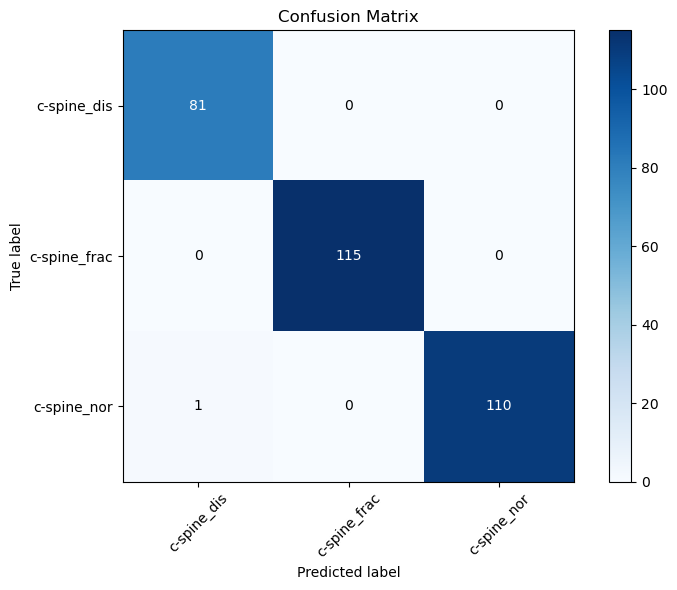

In [4]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
# Get true labels
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels and tick marks
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Display values in each cell
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Generate Predictions
predictions = model.predict(test_generator)  # Assuming you have a generator

# Step 2: Convert Predictions to Labels
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Get True Labels
true_labels = test_generator.classes

# Step 4: Use classification_report
report = classification_report(true_labels, predicted_labels, target_names=['c-spine_dis', 'c-spine_frac', 'c-spine_nor'])

# Print the Classification Report
print(report)


31/31 [==============================] - 13s 406ms/step
              precision    recall  f1-score   support

 c-spine_dis       0.99      1.00      0.99        81
c-spine_frac       1.00      1.00      1.00       115
 c-spine_nor       1.00      0.99      1.00       111

    accuracy                           1.00       307
   macro avg       1.00      1.00      1.00       307
weighted avg       1.00      1.00      1.00       307



In [5]:
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Generate Predictions
predictions = model.predict(test_generator)  # Assuming you have a generator

# Step 2: Convert Predictions to Labels
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Get True Labels
true_labels = test_generator.classes

# Step 4: Get Unique Class Labels
unique_labels = list(set(true_labels))

# Step 5: Use classification_report
report = classification_report(true_labels, predicted_labels, labels=unique_labels)

# Print the Collective Classification Report
print(report)


31/31 [==============================] - 17s 568ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        80
           1       1.00      1.00      1.00       117
           2       1.00      0.98      0.99       107

    accuracy                           0.99       304
   macro avg       0.99      0.99      0.99       304
weighted avg       0.99      0.99      0.99       304



In [10]:
import numpy as np

def calculate_metrics(confusion_matrix):
    num_classes = len(confusion_matrix)

    # Precision, Recall, F1 Score for each class
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    # True Positives for each class
    true_positives = np.diag(confusion_matrix)

    # False Positives and False Negatives for each class
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Calculate Precision, Recall, F1 Score for each class
    for i in range(num_classes):
        precision[i] = true_positives[i] / (true_positives[i] + false_positives[i])
        recall[i] = true_positives[i] / (true_positives[i] + false_negatives[i])
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    # Accuracy
    accuracy = np.sum(true_positives) / np.sum(confusion_matrix)

    return precision, recall, f1_score, accuracy

# Example Confusion Matrix (replace this with your values)
conf_matrix = np.array([[81, 0, 0],
                       [0, 115, 0],
                       [1, 0, 110]])

# Calculate metrics
precision, recall, f1_score, accuracy = calculate_metrics(conf_matrix)

# Display results
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1_score[i]:.4f}")

print(f"Accuracy: {accuracy:.4f}")


Class 0 - Precision: 0.9878, Recall: 1.0000, F1 Score: 0.9939
Class 1 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 2 - Precision: 1.0000, Recall: 0.9910, F1 Score: 0.9955
Accuracy: 0.9967


In [7]:
import numpy as np

def calculate_metrics(confusion_matrix):
    TP = confusion_matrix[0, 0]
    FN = confusion_matrix[0, 1] + confusion_matrix[0, 2]
    FP = confusion_matrix[1, 0] + confusion_matrix[2, 0]
    TN = confusion_matrix[1, 1] + confusion_matrix[1, 2] + confusion_matrix[2, 1] + confusion_matrix[2, 2]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

# Replace this with your actual confusion matrix
conf_matrix = np.array([[81, 0, 0],
                        [0, 115, 0],
                        [1, 0, 110]])

accuracy, precision, recall, f1_score = calculate_metrics(conf_matrix)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


Accuracy: 0.9967
Precision: 0.9878
Recall: 1.0000
F1-score: 0.9939


In [25]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify input shape and number of classes
input_shape = (224, 224, 3)  # Adjust input shape as needed
num_classes = 3  # Adjust for your classification task

# Load the InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

# Create your custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

# Add three fully connected layers
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with SGD optimizer and a specific learning rate
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])

# Train your model with your dataset
model.fit(train_generator, epochs=30, batch_size=10, validation_data=validation_generator)

# Make sure to load your dataset and train the model with the appropriate data and labels.
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/30
141/141 [==============================] - 78s 525ms/step - loss: 0.9883 - accuracy: 0.5103 - val_loss: 0.8290 - val_accuracy: 0.6467
Epoch 2/30
141/141 [==============================] - 70s 495ms/step - loss: 0.8042 - accuracy: 0.6484 - val_loss: 0.6313 - val_accuracy: 0.7500
Epoch 3/30
141/141 [==============================] - 70s 497ms/step - loss: 0.6782 - accuracy: 0.6982 - val_loss: 0.5976 - val_accuracy: 0.7000
Epoch 4/30
141/141 [==============================] - 69s 490ms/step - loss: 0.5998 - accuracy: 0.7367 - val_loss: 0.5473 - val_accuracy: 0.8033
Epoch 5/30
141/141 [==============================] - 66s 469ms/step - loss: 0.5791 - accuracy: 0.7687 - val_loss: 0.5504 - val_accuracy: 0.7700
Epoch 6/30
141/141 [==============================] - 65s 462ms/step - loss: 0.5369 - accuracy: 0.7673 - val_loss: 0.4520 - val_accuracy: 0.8667
Epoch 7/30
141/141 [==============================] - 65s 463ms/step - loss: 0.4955 - accuracy: 0.7900 - val_loss: 0.4070 - val_ac

In [26]:
tf.keras.models.save_model(model,'Test4.hdf5')

C:\Users\swapn\AppData\Local\Temp\ipykernel_10972\30047212.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'Test4.hdf5')


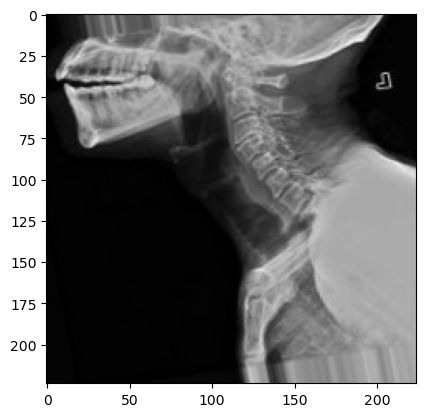

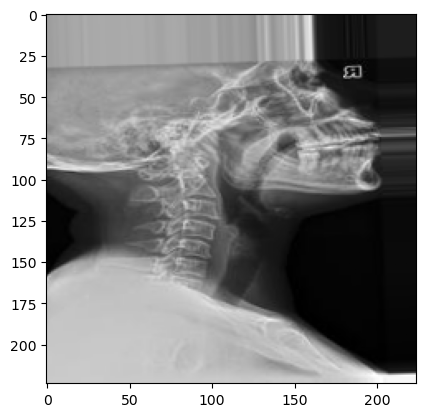

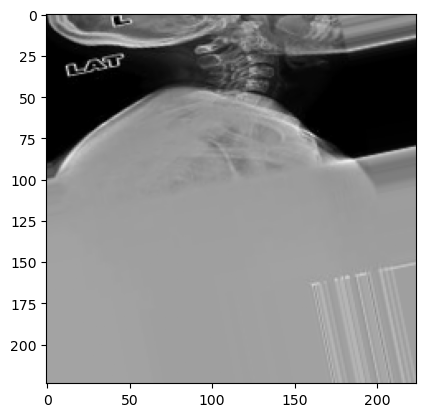

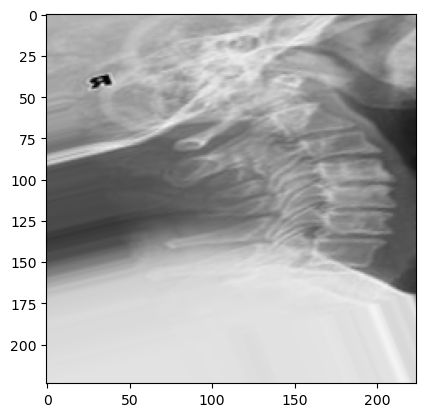

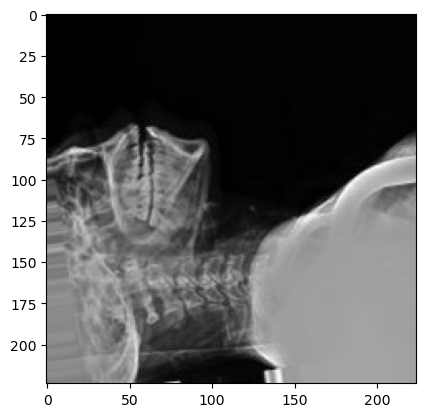

In [28]:
import matplotlib.pyplot as plt

# Get a batch of augmented images
augmented_images, _ = next(train_generator)

# Display the first few images
for i in range(5):
    plt.imshow(augmented_images[i])
    plt.show()


31/31 [==============================] - 19s 586ms/step


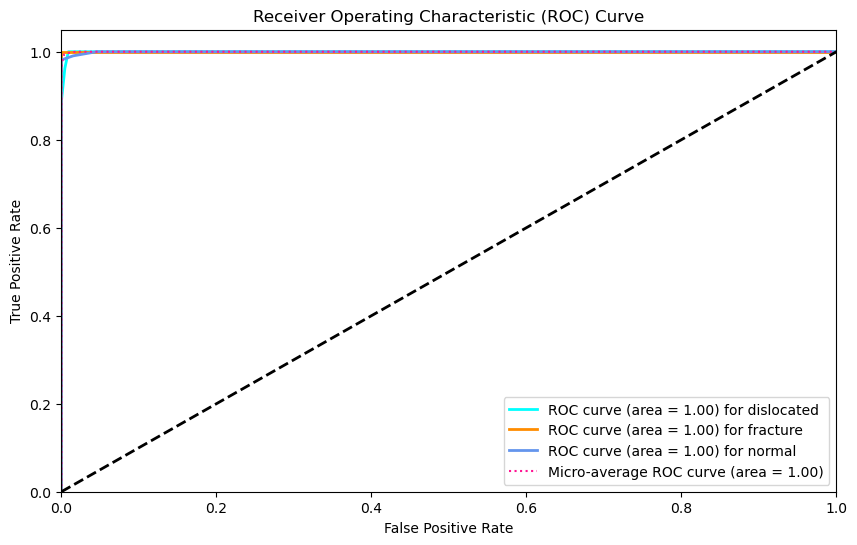

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

model = tf.keras.models.load_model('Test3.hdf5')
# Assuming your model is named 'model' and you have a test_generator
num_classes = 3  # Adjust this to the actual number of classes

# Generate predictions
y_score = model.predict(test_generator)

# Binarize the labels
y_true = label_binarize(test_generator.classes, classes=range(num_classes))

# Define class names
class_names = ['dislocated', 'fracture', 'normal']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':')
plt.legend(loc="lower right", fontsize="small")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [13]:
import numpy as np

# Confusion matrix
conf_matrix = np.array([[80, 0, 0],
                        [0, 117, 0],
                        [2, 0, 105]])

# Calculate TPR and FPR for each class
num_classes = conf_matrix.shape[0]

for i in range(num_classes):
    true_positive = conf_matrix[i, i]
    false_positive = np.sum(conf_matrix[:, i]) - true_positive
    false_negative = np.sum(conf_matrix[i, :]) - true_positive

    tpr = true_positive / (true_positive + false_negative)
    fpr = false_positive / (false_positive + np.sum(conf_matrix[:, i]) - true_positive)

    print(f"Class {i} - TPR (Sensitivity): {tpr:.3f}, FPR: {fpr:.3f}")



Class 0 - TPR (Sensitivity): 1.000, FPR: 0.500
Class 1 - TPR (Sensitivity): 1.000, FPR: nan
Class 2 - TPR (Sensitivity): 0.981, FPR: nan


C:\Users\swapn\AppData\Local\Temp\ipykernel_14520\650277828.py:17: RuntimeWarning: invalid value encountered in long_scalars
  fpr = false_positive / (false_positive + np.sum(conf_matrix[:, i]) - true_positive)


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Define the two confusion matrices
conf_matrix_1 = np.array([[80, 0, 0],
                          [0, 117, 0],
                          [2, 0, 105]])

conf_matrix_2 = np.array([[80, 0, 1],
                          [0, 115, 0],
                          [0, 1, 110]])

# Print classification report for the first model
report_1 = classification_report(np.argmax(conf_matrix_1, axis=1), np.argmax(conf_matrix_1, axis=0),
                                 target_names=['Class 0', 'Class 1', 'Class 2'])
print("Model 1 Classification Report:")
print(report_1)

# Print classification report for the second model
report_2 = classification_report(np.argmax(conf_matrix_2, axis=1), np.argmax(conf_matrix_2, axis=0),
                                 target_names=['Class 0', 'Class 1', 'Class 2'])
print("Model 2 Classification Report:")
print(report_2)


Model 1 Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         1
     Class 1       1.00      1.00      1.00         1
     Class 2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Model 2 Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         1
     Class 1       1.00      1.00      1.00         1
     Class 2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators with data augmentation for training and rescaling for validation and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

batch_size = 10

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    'D:/NDT/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    'D:/NDT/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    'D:/NDT/test',
    shuffle=False,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 1402 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 307 images belonging to 3 classes.


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify input shape and number of classes
input_shape = (224, 224, 3)  # Adjust input shape as needed
num_classes = 3  # Adjust for your classification task

# Load the InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

# Create your custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with SGD optimizer and a specific learning rate
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.95), loss='categorical_crossentropy', metrics=['accuracy'])


# Train your model with your dataset
# model.fit(train_generator, epochs=epochs, validation_data=val_generator)
model.fit(train_generator, epochs=35, batch_size=10, validation_data=validation_generator)
# Make sure to load your dataset and train the model with the appropriate data and labels.
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/35
141/141 [==============================] - 66s 442ms/step - loss: 0.4933 - accuracy: 0.7989 - val_loss: 0.0927 - val_accuracy: 0.9900
Epoch 2/35
141/141 [==============================] - 60s 425ms/step - loss: 0.0891 - accuracy: 0.9800 - val_loss: 0.1103 - val_accuracy: 0.9467
Epoch 3/35
141/141 [==============================] - 60s 426ms/step - loss: 0.0627 - accuracy: 0.9879 - val_loss: 0.0571 - val_accuracy: 0.9933
Epoch 4/35
141/141 [==============================] - 61s 432ms/step - loss: 0.0482 - accuracy: 0.9900 - val_loss: 0.1157 - val_accuracy: 0.9467
Epoch 5/35
141/141 [==============================] - 61s 430ms/step - loss: 0.0438 - accuracy: 0.9893 - val_loss: 0.0372 - val_accuracy: 0.9933
Epoch 6/35
141/141 [==============================] - 60s 427ms/step - loss: 0.0469 - accuracy: 0.9879 - val_loss: 0.0372 - val_accuracy: 0.9933
Epoch 7/35
141/141 [==============================] - 60s 424ms/step - loss: 0.0404 - accuracy: 0.9893 - val_loss: 0.0253 - val_ac

In [6]:
tf.keras.models.save_model(model,'Test8.hdf5')

C:\Users\swapn\AppData\Local\Temp\ipykernel_15140\4210957880.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'Test8.hdf5')


31/31 [==============================] - 10s 333ms/step - loss: 0.0188 - accuracy: 0.9935
Test accuracy: 99.35%


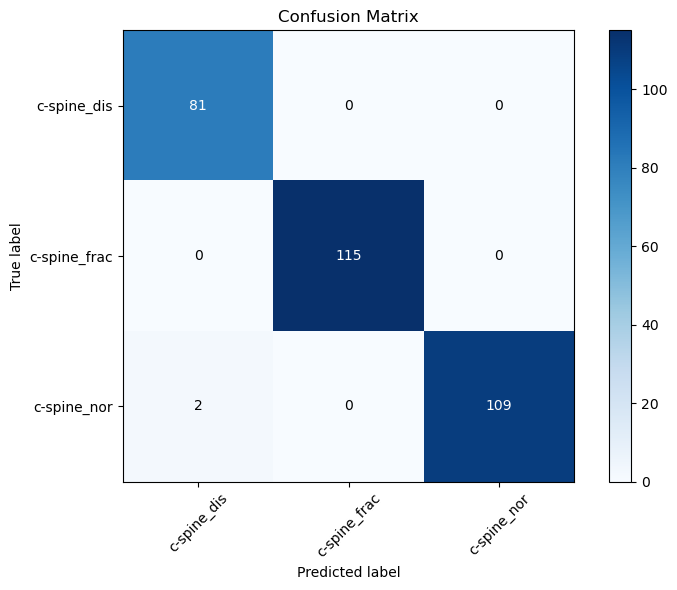

In [7]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
# Get true labels
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels and tick marks
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Display values in each cell
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix
conf_matrix = np.array([[81, 0, 0],
                        [0, 115, 0],
                        [1, 0, 110]])

# Calculate compound accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Calculate compound precision, recall, and f1 score
precision = np.mean(precision_score(range(3), range(3), labels=[0, 1, 2], average=None))
recall = np.mean(recall_score(range(3), range(3), labels=[0, 1, 2], average=None))
f1 = np.mean(f1_score(range(3), range(3), labels=[0, 1, 2], average=None))

print(f'Compound Accuracy: {accuracy * 100:.4f}%')
print(f'Compound Precision: {precision * 100:.4f}%')
print(f'Compound Recall: {recall * 100:.4f}%')
print(f'Compound F1 Score: {f1 * 100:.4f}%')


Compound Accuracy: 99.6743%
Compound Precision: 100.0000%
Compound Recall: 100.0000%
Compound F1 Score: 100.0000%
